In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset

import experiments_utils

Set cells width

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [11]:
INPUT_PATH = "../../data/enron/enron_dataset_splitted_receivers.csv.gz"

Load the dataset

In [12]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')

Filter stuff if necessary

In [13]:
nodes_to_keep = range(dataset.dim)

#### Dataset exploration

Print statistics of the dataset

In [14]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 51,060
               %NZ: 21.77%

Stats. of num. of events per dim:


NameError: name 'pd' is not defined

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')
axs[0].set_ylabel('Number of users')

end_time = max(map(max, dataset.timestamps))
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')
axs[1].set_ylabel('Number of users')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')
axs[2].set_ylabel('Number of users')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

In [ ]:
busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.boxplot(busca_betas, labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print('Median:', np.median(busca_betas))

In [ ]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model

plt.boxplot(busca_beta_ji.flatten(), labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_{ij}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print('Median:', np.median(busca_beta_ji))

In [ ]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
all_delta_ikj = np.hstack([arr.flatten() for arr in wold_model.delta_ikj])

plt.boxplot(all_delta_ikj)
plt.yscale('log')
print(pd.Series(all_delta_ikj).describe())

#### Extract ground truth

Build ground truth adjacency matrix

In [15]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodes_to_keep).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

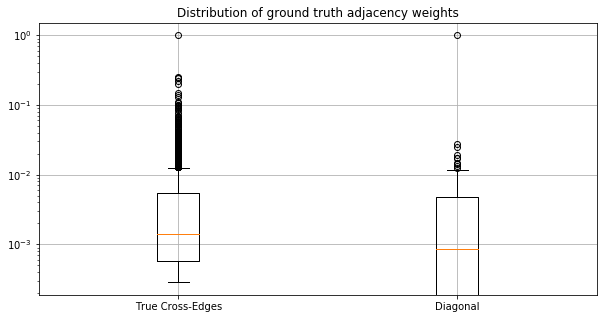

In [60]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adjacency_true[adjacency_true > 0.0], adjacency_true[np.eye(adjacency_true.shape[0]).astype(bool)]],
    labels=['True Cross-Edges', 'Diagonal'])
plt.title('Distribution of ground truth adjacency weights');
plt.yscale('log');

Set variables used for inferences

In [16]:
events = dataset.timestamps
end_time = dataset.timestamps

Set threshold for edge detection evaluation

In [17]:
THRESH = 0.01

---

## Run inference

---

### Run VI

In [21]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [22]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(dataset.timestamps)

In [23]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

a_mean: min:+2.01e-04, max:+9.81e+00
b_mean: min:+1.06e+00, max:+4.04e+00
iter:     1 | dx: +9.7129e+00 | f1-score: 0.08 | relerr: 1.52e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 3.24e+01     
a_mean: min:+4.38e-04, max:+5.06e+00
b_mean: min:+7.35e-01, max:+2.52e+00
iter:     2 | dx: +9.7129e+00 | f1-score: 0.11 | relerr: 1.04e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 6.64e-01     
a_mean: min:+2.04e-04, max:+7.62e+00
b_mean: min:+5.86e-01, max:+2.47e+00
iter:     3 | dx: +2.5641e+00 | f1-score: 0.12 | relerr: 9.46e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 6.82e-01     
a_mean: min:+1.43e-04, max:+9.68e+00
b_mean: min:+5.34e-01, max:+2.30e+00
iter:     4 | dx: +2.0672e+00 | f1-score: 0.14 | relerr: 9.18e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 6.81e-01     
a_mean: min:+1.30e-04, max:+1.13e+01
b_mean: min:+5.07e-01, max:+2.26e+00
iter:     5 | dx: +1.6935e+00 | f1-score: 0.15 | relerr: 9.11e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it:

iter:    41 | dx: +6.9089e-02 | f1-score: 0.19 | relerr: 8.53e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 6.80e-01     
a_mean: min:+1.18e-04, max:+2.10e+01
b_mean: min:+4.33e-01, max:+3.18e+00
iter:    42 | dx: +6.8551e-02 | f1-score: 0.19 | relerr: 8.52e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 6.55e-01     
a_mean: min:+1.18e-04, max:+2.09e+01
b_mean: min:+4.33e-01, max:+3.18e+00
iter:    43 | dx: +6.7767e-02 | f1-score: 0.19 | relerr: 8.50e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 6.85e-01     
a_mean: min:+1.18e-04, max:+2.09e+01
b_mean: min:+4.32e-01, max:+3.19e+00
iter:    44 | dx: +6.7067e-02 | f1-score: 0.19 | relerr: 8.49e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 6.81e-01     
a_mean: min:+1.18e-04, max:+2.09e+01
b_mean: min:+4.32e-01, max:+3.19e+00
iter:    45 | dx: +6.6469e-02 | f1-score: 0.19 | relerr: 8.47e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it: 7.67e-01     
a_mean: min:+1.18e-04, max:+2.08e+01
b_mean: min:+4.32e-01,

KeyboardInterrupt: 

In [30]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1
model_name = type(vi_model).__name__

#adj_hat = adj_hat
adj_hat = adj_hat / beta_hat

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.01)


========== Method: WoldModelVariational

Accuracy: 0.75

Edge counts
------------
Pred: 993.00
True: 2177.00

Error counts
------------
 True Positive: 331.00
False Positive: 662.00
 True Negative: 7161.00
False Negative: 1846.00

Error rates
-----------
 True Positive Rate: 0.15
False Positive Rate: 0.08
 True Negative Rate: 0.92
False Negative Rate: 0.85

F-Score
-------
 F1-Score: 0.21
Precision: 0.33
   Recall: 0.15

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.10
Prec@20: 0.10

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.05000000000000002
10 0.0979999999999999
20 0.17849999999999994



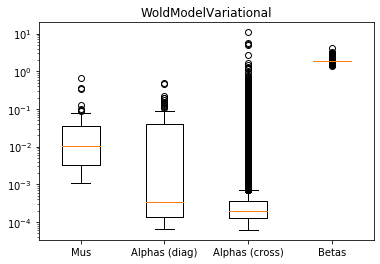

In [31]:
diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([mu_hat.flatten(), adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()], 
            labels=['Mus', 'Alphas (diag)', 'Alphas (cross)', 'Betas']);
plt.yscale('log');
plt.title(model_name);

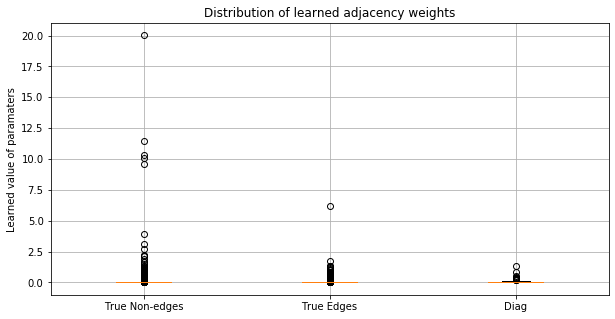

In [82]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0], adj_hat[np.eye(adj_hat.shape[0]).astype(bool)]],
    labels=['True Non-edges', 'True Edges', 'Diag'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

In [84]:
adjacency_true[np.eye(adj_hat.shape[0]).astype(bool)]

array([ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.03,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.02,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,
        0.01,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  1.00,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01,  0.00])

In [85]:
top_edges = np.argsort(adj_hat.flatten())[::-1]
adjacency_true.flatten()[top_edges]

array([ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.15])

---

### Run GB

In [52]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=30000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [58]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))
model_name = type(granger_model).__name__

#adj_hat = adj_hat / beta_hat  # Does not matter

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
adj_hat[diag_mask] = 0


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true_zero_diag, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.21

Edge counts
------------
Pred: 372.00
True: 2106.00

Error counts
------------
 True Positive: 102.00
False Positive: 270.00
 True Negative: 7624.00
False Negative: 2004.00

Error rates
-----------
 True Positive Rate: 0.05
False Positive Rate: 0.03
 True Negative Rate: 0.97
False Negative Rate: 0.95

F-Score
-------
 F1-Score: 0.08
Precision: 0.27
   Recall: 0.05

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.10
Prec@20: 0.10

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.14845360824742254
10 0.16907216494845356
20 0.14536082474226802



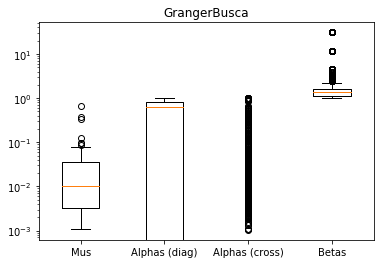

In [56]:
diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([mu_hat.flatten(), adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()], 
            labels=['Mus', 'Alphas (diag)', 'Alphas (cross)', 'Betas']);
plt.yscale('log');
plt.title(model_name);

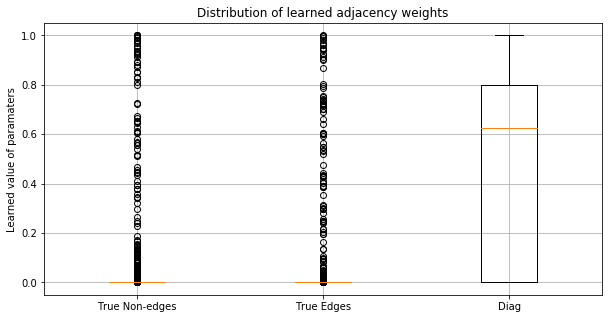

In [57]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0], adj_hat[np.eye(adj_hat.shape[0]).astype(bool)]],
    labels=['True Non-edges', 'True Edges', 'Diag'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

In [171]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=0.03204881895953531, pvalue=0.0007088376296667749)

In [172]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

0.05585231454261796

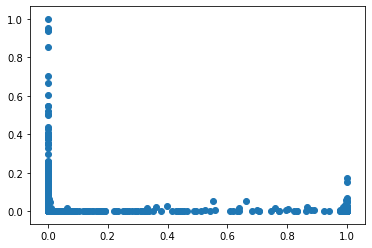

In [173]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [174]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [175]:
mean_rank_corr

0.05585231454261796

(array([  6.00,  31.00,  10.00,  13.00,  18.00,  14.00,   1.00,   2.00,   2.00,   2.00]),
 array([-0.16, -0.10, -0.03,  0.03,  0.10,  0.16,  0.22,  0.29,  0.35,  0.42,  0.48]),
 <a list of 10 Patch objects>)

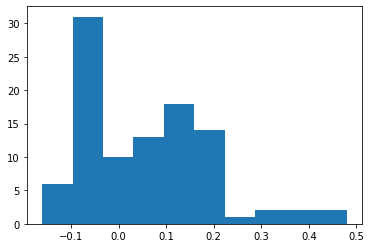

In [176]:
plt.hist(rank_corr_per_dim)

In [177]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

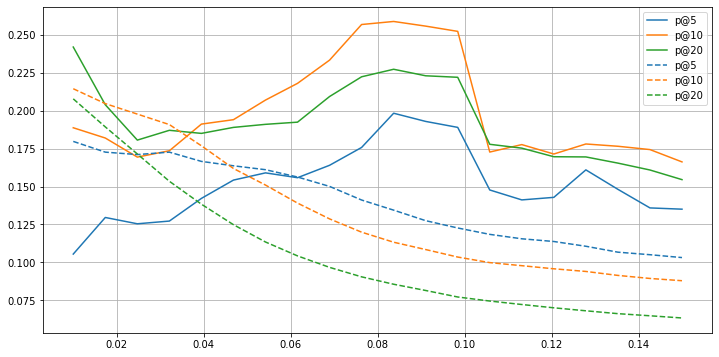

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();